## Installing and import packages

In [ ]:
# !pip install googletrans==3.1.0a0

In [ ]:
# !pip install pymorphy2

In [2]:
!pip install transformers datasets eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 467 kB/s 
     |████████████████████████████████| 451 kB 14.3 MB/s 
     |████████████████████████████████| 216 kB 13.9 MB/s 
     |████████████████████████████████| 7.6 MB 9.7 MB/s 
     |████████████████████████████████| 182 kB 17.0 MB/s 
     |████████████████████████████████| 132 kB 17.6 MB/s 
     |████████████████████████████████| 212 kB 19.7 MB/s 
     |████████████████████████████████| 127 kB 19.8 MB/s 
     |████████████████████████████████| 133 kB 19.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=616910a2615a4bc0d309f6b6db7499cb2e93c577b3edfe2e6bc62fc096cf196e
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling u

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# from pymorphy2 import MorphAnalyzer

# import eli5

import re, string
from collections import defaultdict, Counter
from itertools import chain

import torch
from torch.utils.data import Dataset, DataLoader

import pyarrow as pa
from datasets import Dataset

import transformers as ppb # pytorch transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding, 
    pipeline,
    Trainer,
    TrainingArguments)

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sn

from google.colab import drive
from google.colab import output

# from googletrans import Translator
# translator = Translator()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset of english sarcasm -- translation

In [ ]:
df_en = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train.csv')

In [ ]:
df_en.head()

,Y,text
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


In [ ]:
df_ru = pd.DataFrame(columns=['comment', 'label'])

In [ ]:
for index, row in df_en.iterrows():
    df_ru.loc[index + 1] = [translator.translate(row['text'], dest='ru').text] + [row['Y']]
    if not(index % 100):
      print(f"{index} is translated")

In [ ]:
df_ru.head()

,comment,label
1,Тридцатилетние ученые представили часы конца с...,1
2,представитель Демократической партии полностью...,0
3,Ешьте овощи 9 восхитительно разных рецептов,0
4,ненастная погода мешает лжецу добраться до работы,1
5,мать довольно близко подходит к правильному ис...,1


Все переведено и сохранено (НЕ НАЖИМАТЬ!! пересчитывать достаточно долго)

In [ ]:
df_ru.to_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru.csv', index=False)

Для последующих запусков (считываем датафрейм)

In [ ]:
df_ru = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru.csv')

## Dataset of Russian jokes -- read_csv

In [ ]:
df_jokes = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/jokes.csv')
df_jokes = df_jokes.drop(columns=['theme', 'rating'])
df_jokes = df_jokes.rename(columns={"text": "comment"})
df_jokes['label'] = 1

In [ ]:
df_jokes.head()

,comment,label
0,На суде в Стамбуле обвиняемый сказал:\r\n- На...,1
1,"- Вы продолжаете утверждать, что обвиняемый н...",1
2,"На суде.\r\n- Итак, когда дело дошло до столкн...",1
3,Старую леди сбил автомобиль. На суде ее спраши...,1
4,"Судья говорит:\r\n- Согласно вашей жалобе, об...",1


In [ ]:
df_jokes.to_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru_jokes.csv', index=False)

## Make the final dataset

In [ ]:
df_ru_jokes = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru_jokes.csv')
df_en_sarcasm_or_not = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru.csv')

df_en_non_sarcasm = df_en_sarcasm_or_not.query('label==0')
df_en_sarcasm = df_en_sarcasm_or_not.query('label==1')

print("Translated non-sarcasm: ", len(df_en_non_sarcasm))
print("Translated sarcasm: ", len(df_en_sarcasm))
print("Russian jokes: ", len(df_ru_jokes))

Translated non-sarcasm:  10479
Translated sarcasm:  9554
Russian jokes:  130204


In [ ]:
# # simple dataset
# non_sarcasm_num = 500
# sarcasm_num = 200
# jokes_num = 300

# # simple dataset without jokes
# non_sarcasm_num = 500
# sarcasm_num = 500
# jokes_num = 0

# big dataset
non_sarcasm_num = 10000
sarcasm_num = 5000
jokes_num = 5000

df_non_sarcasm = df_en_non_sarcasm.sample(frac=1).iloc[0:non_sarcasm_num, :] 
df_sarcasm = df_en_sarcasm.sample(frac=1).iloc[0:sarcasm_num, :] 
df_jokes = df_ru_jokes.sample(frac=1).iloc[0:jokes_num, :] 

df = pd.concat([df_non_sarcasm, df_sarcasm, df_jokes]).sample(frac=1).reset_index(drop=True)

# delete punctuation
df = df.replace(to_replace=r'\r', value='', regex=True)
df = df.replace(to_replace=r'\n', value='', regex=True)
df.comment = df.comment.str.replace('[^\w\s]','')

<ipython-input-20-a2107a57d522>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df.comment = df.comment.str.replace('[^\w\s]','')


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


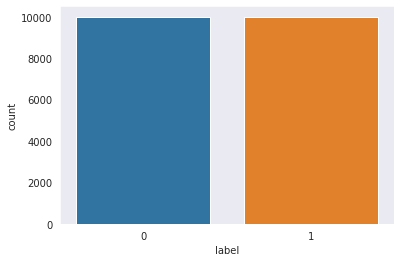

In [ ]:
sns.set_style("dark")
sns.countplot(df.label)

In [ ]:
df.head()

,comment,label
0,Тильда Суинтон не в этом клипе из большого всп...,0
1,Что нужно сделать чтобы тебя выгнали из политики,0
2,mdt Живу в общаге Туалет общии на несколько ка...,1
3,antonioя думаю если все будет идти также я уво...,1
4,Джон Дауд уходит с поста главного адвоката Тра...,0


In [ ]:
## proportion train-test
n_train = 0.7
n_test = 0.3

ind = round(len(df)*n_train)
df_train = df.iloc[0:ind, :] 
df_test = df.iloc[ind:, :] 
print(len(df_train), len(df_test))

14000 6000


In [ ]:
df_train.to_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv', index=False)

## Data preprocessing for LogReg concept

I strongly believe that we should preprosess our data AFTER the translation (as it is done here), because such way we won't loose some set expressions

Remove links (just in case)

In [ ]:
def remove_links(text): 
    return re.sub(r'http\S+', '', text)

Remove the text in brackets

In [ ]:
def remove_between_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

Make a set of russian stop words including punctuation signs and digits

In [ ]:
nltk.download("stopwords")
ru_stopwords = set(stopwords.words('russian'))
punctuation = list(string.punctuation) + [str(i) for i in range(10)] + ['']
ru_stopwords.update(punctuation)

print(ru_stopwords)

{'', '[', '+', 'тем', 'ж', 'вы', 'еще', 'будто', '{', 'нельзя', 'иногда', 'при', '!', 'есть', 'наконец', 'не', 'уже', 'нее', 'да', 'этого', 'три', 'ее', 'свою', 'были', 'мне', 'же', 'том', 'вот', 'один', 'бы', 'хоть', '~', 'себя', '=', 'когда', ';', 'то', 'у', 'чего', 'чтобы', 'кто', 'никогда', 'об', 'ей', 'такой', '0', '`', 'сам', 'уж', 'а', 'вас', 'потому', 'эту', '4', 'к', 'они', 'мой', '/', '$', '8', 'другой', 'даже', 'перед', 'за', 'где', 'нас', 'теперь', 'ведь', 'нет', 'для', '7', 'нибудь', 'по', 'между', 'его', 'было', 'ну', 'был', 'всего', '^', '(', 'быть', 'почти', 'их', 'опять', 'может', 'я', 'под', '"', '<', 'ней', 'до', '9', '-', '}', '.', 'этот', 'тоже', 'во', 'больше', 'мы', 'этом', 'конечно', '_', 'потом', 'впрочем', 'как', 'много', '6', 'всегда', ')', 'сейчас', '3', 'что', 'на', 'более', '&', '1', '?', 'им', ',', 'только', 'там', 'раз', 'всех', '>', 'того', 'в', 'и', '2', 'вдруг', '%', 'себе', 'разве', 'ему', 'над', 'ты', 'через', 'эти', 'всю', 'о', 'тут', 'с', ':', '\\

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Transfer sentences to lists of tokens, remove stopwords

In [ ]:
class Tokenizer:
    def __init__(self, word_pattern="[\w']+"):
        self.word_pattern = re.compile(word_pattern)

    def tokenize(self, text):
        return self.word_pattern.findall(text)

In [ ]:
tok = Tokenizer()
def tokenize_and_remove_stopwords(text): 
    return [word for word in tok.tokenize(text) if word not in ru_stopwords]

Lemmatize each word 

In [ ]:
morph = MorphAnalyzer()
def lemmatization(text_list):
    return [morph.parse(word)[0].normal_form for word in text_list] 

Preprosess data

In [ ]:
def preprosess_data(dataframe):
    dataframe['comment'] = dataframe['comment'].apply(remove_links)
    dataframe['comment'] = dataframe['comment'].apply(remove_between_brackets)
    # dataframe['comment'] = dataframe['comment'].apply(tokenize_and_remove_stopwords)
    # dataframe['comment'] = dataframe['comment'].apply(lemmatization)
    return dataframe

df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv')
df_train_preprosessed = preprosess_data(df_train)
df_test_preprosessed = preprosess_data(df_test)

In [ ]:
df_train_preprosessed.head()

,comment,label
0,Медицинские работники проверяют факты сцены се...,0
1,Начальник полиции Хьюстона говорит что ему над...,0
2,Сенатордемократ призывает директора ЦРУ уйти в...,0
3,местный мужчина бумажное полотенце черная дыра,1
4,Задача оппозиции не поносить власть а только н...,1


In [ ]:
df_test_preprosessed.head()

,comment,label
0,10летний мальчик отрицает обвинения в симпатия...,1
1,Мужчина наконец поставил Super Mario Bros на п...,1
2,Жилбыл Мальчикспальчик Вырос он и стал Дядясруку,1
3,Здравствуите Я бы хотел назвать сына Сергеем ...,1
4,Приходит грузин к сексопатологу Доктор у меня ...,1


## LogReg (baseline score)

Import data

In [ ]:
X_train = df_train_preprosessed.comment
Y_train = df_train_preprosessed.label
X_test = df_test_preprosessed.comment
Y_test = df_test_preprosessed.label

Tf-Idf vectorizer

In [ ]:
counter_tfidf = TfidfVectorizer(stop_words=ru_stopwords, ngram_range=(1,1), lowercase=True)

count_train = counter_tfidf.fit_transform(X_train)
count_test = counter_tfidf.transform(X_test)

In [ ]:
print(count_train[0]) # the tf-idf is between [0,1]

  (0, 2998)	0.3857585506928618
  (0, 39553)	0.3857585506928618
  (0, 39271)	0.29561590719872644
  (0, 43164)	0.319020300717423
  (0, 46737)	0.3498871863590852
  (0, 34868)	0.3857585506928618
  (0, 36219)	0.33671481893444355
  (0, 21671)	0.3586229111126824


LogReg model 

In [ ]:
model_lr = LogisticRegression(random_state = 12345, max_iter = 10000, n_jobs = -1) # -1 means using all processors (CPU cores)

model_lr.fit(count_train, Y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [ ]:
eli5.show_weights(estimator=model_lr, feature_names=counter_tfidf.get_feature_names(), top=(10, 10))

Weight?,Feature
+3.169,спрашивает
+2.895,нация
+2.767,вчера
+2.598,мужик
+2.592,тебе
+2.553,мужчина
+2.503,жена
+2.482,сообщить
+2.469,сообщают
+2.410,такои


Predictions

Precision:  0.7868333333333334
Recall:  0.7868333333333334
F1_score:  0.7868333333333334


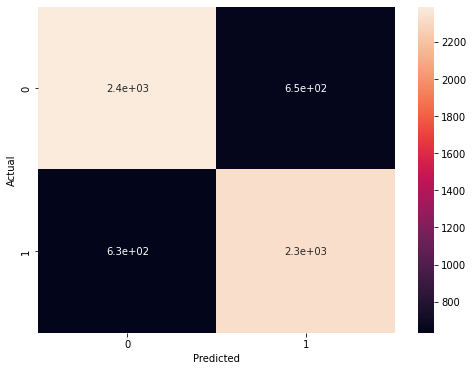

In [ ]:
def test_data_analysis(Y_pred, Y_test):
    precision = accuracy_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred, average='micro')
    F1_score = f1_score(Y_test, Y_pred, average='micro')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1_score: ", F1_score) 
    data = {'y_Actual': Y_test, 'y_Predicted': Y_pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (8, 6))
    sn.heatmap(confusion_matrix, annot=True)

Y_pred = model_lr.predict(count_test)
test_data_analysis(Y_pred, Y_test)

## Transformers (good score)

Links/Tutorials:


*   https://habr.com/ru/post/562064/
*   https://huggingface.co/cointegrated/rubert-tiny




### Customized Dataset class

The __len__ method returns the length of our dataset. The __getitem__ method returns a dictionary that consists of the source text itself, a list of tokens, an attention mask, and a class label. In __encoding__, we indicate to the tokenizer that the source text should be framed with service tokens add_special_tokens=True, and also supplement the received vectors to the maximum length padding='max_len'.

In [5]:
class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx][:self.max_len])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

### BERT Classifier model

Downloading the Russian-language BERT model from the huggingface rupert-tiny repository. https://huggingface.co/cointegrated/rubert-tiny

For classification, it is necessary to add a fully connected layer, the number of inputs of which is the internal dimension of the embedding of the network, and the output is the number of classes for classification. In our case, we classify into 2 classes, and the internal dimension can be obtained by running the following command:

In [6]:
class BertClassifier:

    def __init__(
        self,
        model_path,
        tokenizer_path,
        n_classes=2,
        epochs=1,
        batch_size=2,
        model_save_path='/content/bert.pt'
        ):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.batch_size = batch_size
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
    
    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer, self.max_len)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer, self.max_len)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, self.batch_size, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, self.batch_size, shuffle=True)

        # helpers initialization
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
                )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
            
    def fit(self):
        self.model.train()
        losses = []
        correct_predictions = 0
        loader = tqdm(self.train_loader)
        for data in loader:
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    
    def valid(self):
        self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            loader = tqdm(self.valid_loader)
            for data in loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss
    
    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.valid()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        # self.model = torch.load(self.model_save_path)
    
    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

    def test_data_analysis(self, X_test, Y_test):
        pred = [self.predict(comment) for comment in X_test]
        precision = accuracy_score(Y_test, pred)
        recall = recall_score(Y_test, pred, average='micro')
        F1_score = f1_score(Y_test, pred, average='micro')
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1_score: ", F1_score) 
        data = {'y_Actual': Y_test, 'y_Predicted': pred}
        df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
        confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
        plt.figure(figsize = (8, 6))
        sn.heatmap(confusion_matrix, annot=True)



### Set, train, test

Set params

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny2',
        tokenizer_path='cointegrated/rubert-tiny2',
        n_classes=2,
        epochs=10,
        batch_size=64,
        model_save_path='/content/drive/MyDrive/Sarcastic_сomments/bert.pt'
)

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/401 [00:00<?, ?B/s]

Make preparation

In [8]:
df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv')

X = df_train.comment
Y = df_train.label

train_texts, val_texts, train_labels, val_labels = train_test_split(X, Y, test_size=0.15)

classifier.preparation(
        X_train=list(train_texts),
        y_train=list(train_labels),
        X_valid=list(val_texts),
        y_valid=list(val_labels)
    )

Train our model

In [ ]:
classifier.train()

Epoch 1/10


  0%|          | 0/186 [00:00<?, ?it/s]

Train loss 0.5307893429392128 accuracy 0.7327731092436975


  0%|          | 0/33 [00:00<?, ?it/s]

Val loss 0.40026126485882385 accuracy 0.8157142857142857
----------
Epoch 2/10


  0%|          | 0/186 [00:00<?, ?it/s]

Train loss 0.387519444188764 accuracy 0.8212605042016807


  0%|          | 0/33 [00:00<?, ?it/s]

Val loss 0.3457536372271451 accuracy 0.8385714285714285
----------
Epoch 3/10


  0%|          | 0/186 [00:00<?, ?it/s]

Train loss 0.3290849784689565 accuracy 0.8560504201680672


  0%|          | 0/33 [00:00<?, ?it/s]

Val loss 0.32944349312421045 accuracy 0.8466666666666667
----------
Epoch 4/10


  0%|          | 0/186 [00:00<?, ?it/s]

Train loss 0.2893875533694862 accuracy 0.8757983193277311


  0%|          | 0/33 [00:00<?, ?it/s]

Val loss 0.336957338181409 accuracy 0.8514285714285714
----------
Epoch 5/10


  0%|          | 0/186 [00:00<?, ?it/s]

Predict zero comment

In [ ]:
# normal sentence
print(classifier.predict("Позвони мне завтра вечером"))

0


In [ ]:
# joke
print(classifier.predict("В дверь никто не постучал. «Пустое множество» — подумал Штирлиц"))

1


In [ ]:
# sarcasm
print(classifier.predict("Продолжайте говорить. Я всегда зеваю, когда мне интересно"))

1


Test our model

Precision:  0.8303333333333334
Recall:  0.8303333333333334
F1_score:  0.8303333333333333


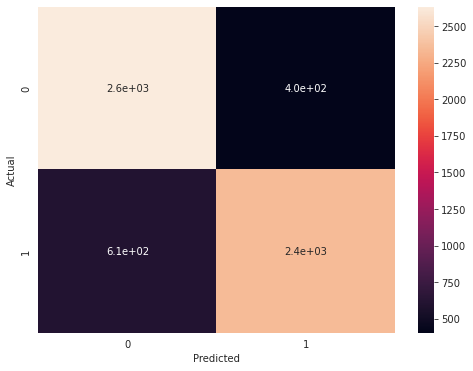

In [ ]:
X_test = df_test.comment
Y_test = df_test.label

classifier.test_data_analysis(X_test, Y_test)

## RNN (not so good score)

In [ ]:
mvs_const = 30000

### Tokenization/Vocab/Embedding

Tokenization

In [ ]:
class Tokenizer:
    def __init__(self, word_pattern="[\w']+"):
        self.word_pattern = re.compile(word_pattern)

    def tokenize(self, text):
        return self.word_pattern.findall(text)

In [ ]:
tok = Tokenizer()
def tokenize_func(text): 
    return [word for word in tok.tokenize(text)] 

Preprocess the data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv')
df_train_preprosessed = df_train
df_train_preprosessed['comment'] = df_train_preprosessed['comment'].apply(tokenize_func)

Building vocab class (NLP HW2 code)

In [ ]:
class Vocab:
    def __init__(self, tokenized_texts, max_vocab_size=None):
        """
        Builds a vocabulary by concatenating all tokenized texts and counting words.
        Most common words are placed in vocabulary, others are replaced with [UNK] token
        :param tokenized_texts: texts to build a vocab
        :param max_vocab_size: amount of words in vocabulary
        """
        counts = Counter(chain(*tokenized_texts))
        max_vocab_size = max_vocab_size or len(counts)
        common_pairs = counts.most_common(max_vocab_size)
        self.PAD_IDX = 0
        self.UNK_IDX = 1
        self.EOS_IDX = 2
        self.itos = [pair[0] for pair in common_pairs]
        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def vectorize(self, text):
        """
        Maps each token to it's index in the vocabulary
        :param text: sequence of tokens
        :return: vectorized sequence
        """
        return [self.stoi.get(tok, self.UNK_IDX) for tok in text]

    def __iter__(self):
        return iter(self.itos)

    def __len__(self):
        return len(self.itos)

Embedding matrix create function (NLP HW2 code)

In [ ]:
def prepare_emb_matrix(gensim_model, vocab: Vocab):

    mean = gensim_model.vectors.mean(1).mean()
    std = gensim_model.vectors.std(1).mean()
    vec_size = gensim_model.vector_size
    emb_matrix = torch.zeros((len(vocab), vec_size))
    for i, word in enumerate(vocab.itos[1:], 1):
        try:
            emb_matrix[i] = torch.tensor(gensim_model.get_vector(word))
        except KeyError:
            emb_matrix[i] = torch.randn(vec_size) * std + mean
    return emb_matrix

In [ ]:
vocab = Vocab(df_train_preprosessed['comment'].to_list(), max_vocab_size=mvs_const)

https://github.com/natasha/navec -- not bad glove model's

In [ ]:
!pip install navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-12-17 17:57:25--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.6MB/s    in 3.4s    

2022-12-17 17:57:29 (14.9 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
glove_model = navec.as_gensim

Embedding matrix creation (there are much bigger and better models, it's test)

In [ ]:
emb_matrix = prepare_emb_matrix(glove_model, vocab)

### Class RecurrentClassifier

In [ ]:
class RecurrentClassifier(torch.nn.Module):
    def __init__(self, vocab, emb_matrix):
        super().__init__()
        self.vocab = vocab
        self.emb_matrix = emb_matrix
        self.embeddings = torch.nn.Embedding.from_pretrained(emb_matrix, freeze=True,
                                                             padding_idx=vocab.PAD_IDX)

        self.cell = torch.nn.GRU(input_size=emb_matrix.size(1),
                                 batch_first=True,
                                 hidden_size=100,
                                 num_layers=3,
                                 dropout=0.1,
                                 bidirectional=True,
                                 )

        self.out_activation = torch.nn.Sigmoid()
        self.out_dropout = torch.nn.Dropout(0.1)
        cur_out_size = 600
        out_layers = []
        for cur_hidden_size in [40]:
            out_layers.append(torch.nn.Linear(cur_out_size, cur_hidden_size))
            cur_out_size = cur_hidden_size
        out_layers.append(torch.nn.Linear(cur_out_size, 2))
        # out_layers.append(self.out_dropout)
        out_layers.append(self.out_activation)
        self.out_proj = torch.nn.Sequential(*out_layers)

    def forward(self, input):
        embedded = self.embeddings(input.data)
        states, last_state = self.cell(torch.nn.utils.rnn.PackedSequence(embedded,
                                                                         input.batch_sizes,
                                                                         sorted_indices=input.sorted_indices,
                                                                         unsorted_indices=input.unsorted_indices))
        
        if isinstance(last_state, tuple):
            last_state = last_state[0]
        last_state = last_state.transpose(0, 1)
        last_state = last_state.reshape(last_state.size(0), -1)
        return self.out_proj(last_state)

### Class Trainer

In [ ]:
class Trainer:
    def __init__(self, config):

        self.config = config
        self.n_epochs = config["n_epochs"]
        self.setup_opt_fn = lambda model: torch.optim.Adam(model.parameters(),
                                                           config["lr"],
                                                           weight_decay=config["weight_decay"])
        # self.setup_sheduler = lambda model: torch.optim.lr_scheduler.StepLR(self.setup_opt_fn(model),
        #                                                                     step_size=14, gamma=0.4)
        self.model = None
        self.opt = None
        self.sheduler = None
        self.history = None
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.device = config["device"]
        self.verbose = config.get("verbose", True)

    def fit(self, model, train_loader, val_loader):

        self.model = model.to(self.device)
        self.opt = self.setup_opt_fn(self.model)
        # self.sheduler = self.setup_sheduler(self.model)
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}
        for epoch in range(self.n_epochs):
            print(f"epoch: {epoch+1}")
            train_info = self._train_epoch(train_loader)
            val_info = self._val_epoch(val_loader)
            self.history["train_loss"].extend(train_info["train_loss"])
            self.history["val_loss"].append(val_info["loss"])
            self.history["val_acc"].append(val_info["acc"])
            # self.save(f"/content/drive/MyDrive/NLP_HW2_data/gensim_model_{epoch+1}.ckpt")
            # if epoch != 0:
            #    self.sheduler.step()
        return self.model.eval()

    def _train_epoch(self, train_loader):
        self.model.train()
        losses = []
        if self.verbose:
            train_loader = tqdm(train_loader)
        for batch in train_loader:
            self.model.zero_grad()
            texts, labels = batch
            logits = self.model.forward(texts.to(self.device))
            loss = self.loss_fn(logits, labels.to(self.device))
            loss.backward()
            self.opt.step()
            loss_val = loss.item()
            losses.append(loss_val)
        if self.verbose:
            train_loader.set_description(f"Loss={np.mean(losses):.3}")
            print(f"Loss={np.mean(losses):.3}")
        return {"train_loss": losses}

    def _val_epoch(self, val_loader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_loader = tqdm(val_loader)
        with torch.no_grad():
            for batch in val_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                all_logits.append(logits)
                all_labels.append(labels)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        if self.verbose:
            val_loader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
            print(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {"acc": acc, "loss": loss}

    def predict(self, test_loader):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                predictions.extend(logits.argmax(1).tolist())
        return np.asarray(predictions)

### Class TextDataset

pandas to dataset (save time)

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts, labels, vocab: Vocab):
        self.texts = tokenized_texts
        self.labels = labels
        self.vocab = vocab

    def __getitem__(self, item):
        return self.vocab.vectorize(self.texts[item]) + [self.vocab.EOS_IDX], self.labels[item]

    def __len__(self):
        return len(self.texts)

    def collate_fn(self, batch):
        """
        Technical method to form a batch to feed into recurrent network
        """
        return torch.nn.utils.rnn.pack_sequence([torch.tensor(pair[0]) for pair in batch], 
                                                enforce_sorted=False), torch.tensor([pair[1] for pair in batch])

### Set, train, test

Creating dataloaders

In [ ]:
X = df_train_preprosessed.comment
Y = df_train_preprosessed.label

train_texts, val_texts, train_labels, val_labels = train_test_split(X, Y, test_size=0.2)
train_dataset = TextDataset(train_texts.to_list(), train_labels.to_list(), vocab)
val_dataset = TextDataset(val_texts.to_list(), val_labels.to_list(), vocab)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=64,
                                               shuffle=True,
                                               collate_fn=train_dataset.collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=64,
                                             shuffle=False,
                                             collate_fn=val_dataset.collate_fn)

Params

In [ ]:
trainer_config = {
    "lr": 1e-3,
    "n_epochs": 10,
    "weight_decay": 1e-6,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [ ]:
# torch.seed()
clf_model = RecurrentClassifier(vocab, emb_matrix)

t = Trainer(trainer_config)
t.fit(clf_model, train_dataloader, val_dataloader)

epoch: 1


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.568


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.541; Acc:0.76
epoch: 2


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.515


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.533; Acc:0.766
epoch: 3


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.486


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.524; Acc:0.772
epoch: 4


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.465


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.531; Acc:0.771
epoch: 5


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.444


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.525; Acc:0.779
epoch: 6


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.428


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.523; Acc:0.781
epoch: 7


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.418


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.532; Acc:0.773
epoch: 8


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.404


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.527; Acc:0.782
epoch: 9


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.397


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.532; Acc:0.775
epoch: 10


  0%|          | 0/175 [00:00<?, ?it/s]

Loss=0.395


  0%|          | 0/44 [00:00<?, ?it/s]

Loss=0.535; Acc:0.77


RecurrentClassifier(
  (embeddings): Embedding(30000, 300, padding_idx=0)
  (cell): GRU(300, 100, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (out_activation): Sigmoid()
  (out_dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Sequential(
    (0): Linear(in_features=600, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=2, bias=True)
    (2): Sigmoid()
  )
)

In [ ]:
def predict(model, comment):
    tok_text = tok.tokenize(comment)
    indexed_text = torch.tensor(vocab.vectorize(tok_text)).to(t.device)
    label = model(torch.nn.utils.rnn.pack_sequence([indexed_text])).argmax().item()
    return label

print(predict(t.model, "Завтра пойду в магазин, ты со мной?"))
print(predict(t.model, "Мне смешно"))
print(predict(t.model, "Продолжайте говорить. Я всегда зеваю, когда мне интересно"))

0
1
1


Precision:  0.7883333333333333
Recall:  0.7883333333333333
F1_score:  0.7883333333333333


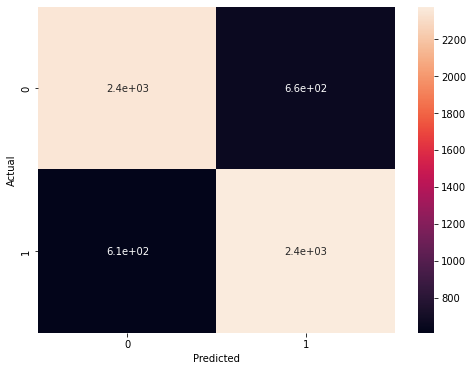

In [ ]:
def test_data_analysis(X_test, Y_test):
    Y_pred = [predict(t.model, comment) for comment in X_test]
    precision = accuracy_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred, average='micro')
    F1_score = f1_score(Y_test, Y_pred, average='micro')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1_score: ", F1_score) 
    data = {'y_Actual': Y_test, 'y_Predicted': Y_pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (8, 6))
    sn.heatmap(confusion_matrix, annot=True)

df_test = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv')
X_test = df_test.comment
Y_test = df_test.label

test_data_analysis(X_test, Y_test)